# Kirchhoff migration of the Volve synthetic data without free-surface

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.twoway import AcousticWave2D

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

In [2]:
# Jump on sources / recs (for quick testing)
js = 1
jr = 1

## Model, geometry, and data

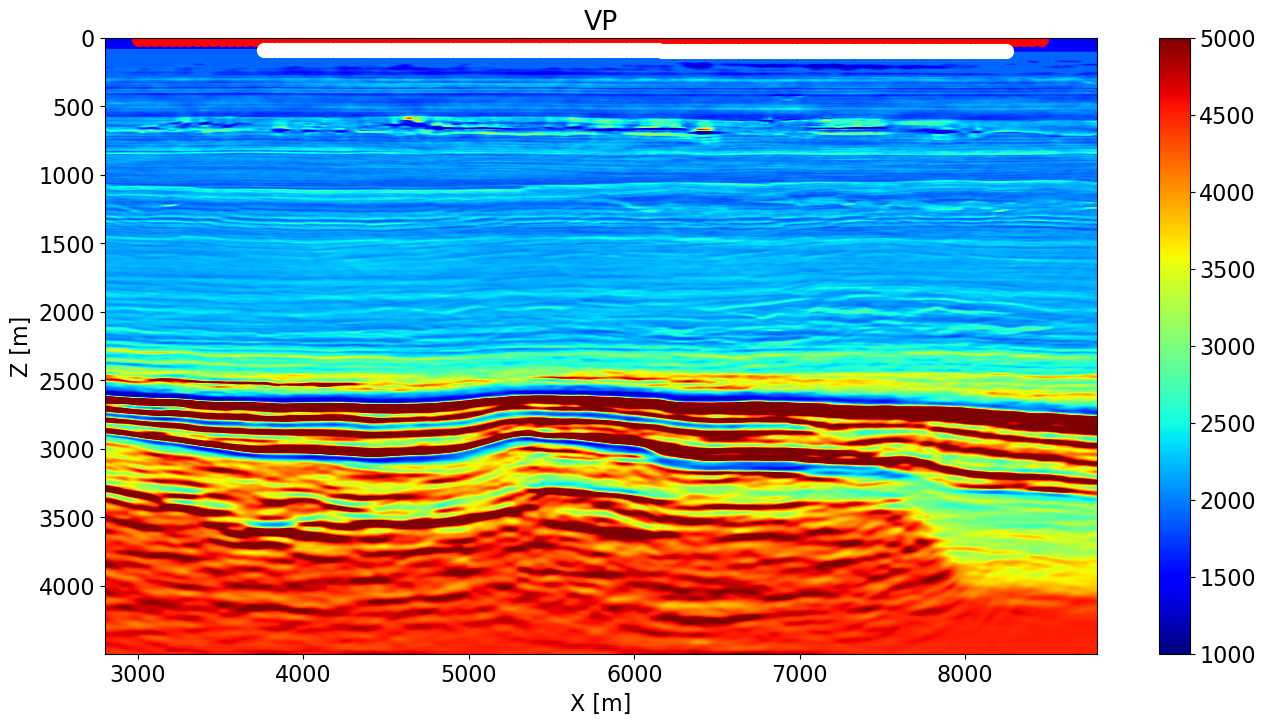

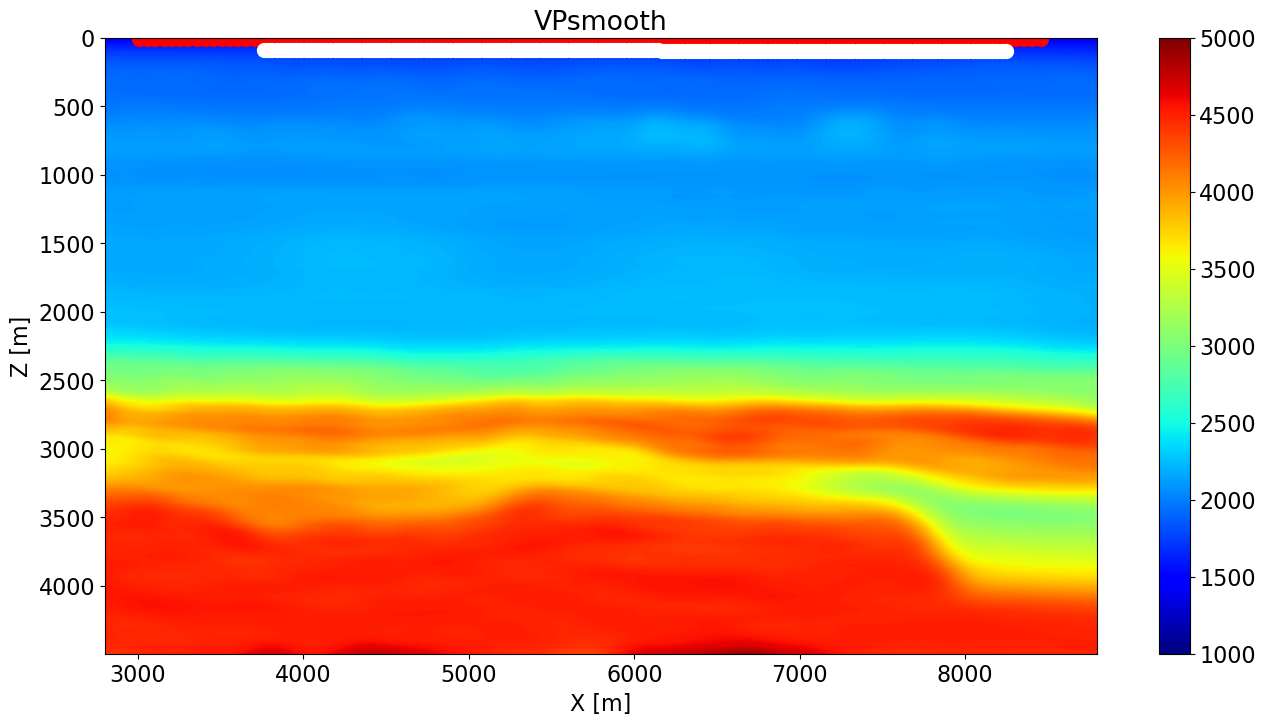

In [3]:
# Load from input file
inputdata = np.load('input_nofs_full_volvesynth.npz')

# Velocity 
vel = inputdata["vel"].T

# Smooth velocity
nsmooth = 41
smooth = np.ones(nsmooth)/nsmooth
velsm = filtfilt(smooth, 1, filtfilt(smooth, 1, vel).T).T
 
nx, nz = vel.shape
x = inputdata["x"]
z = inputdata["z"]
s = inputdata["s"][:, ::js]
r = inputdata["r"][:, ::jr]
ns, nr = s.shape[1], r.shape[1]
nx, nz = x.size, z.size

t = inputdata['t']
dt = t[1]
d = inputdata['p'].transpose(0, 2, 1)[::js, ::jr]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
plt.colorbar(im);

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth')
ax.axis('tight')
plt.colorbar(im);

## Convert from global to local grid

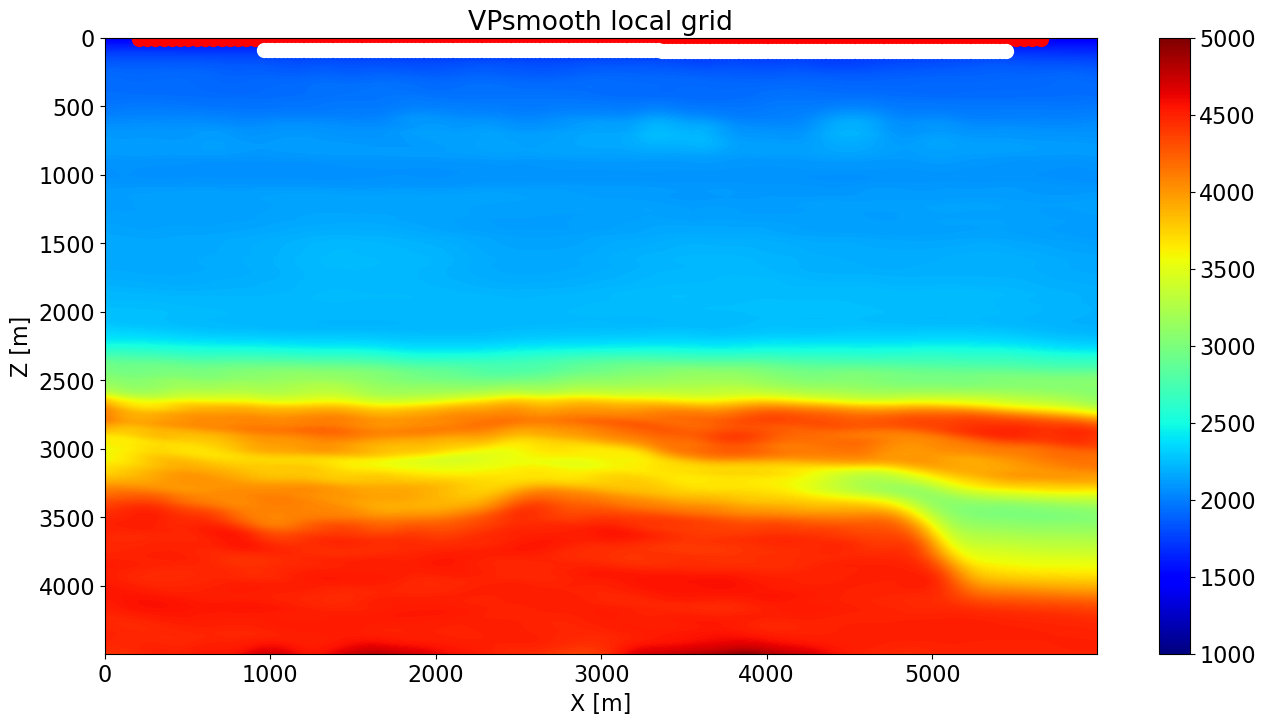

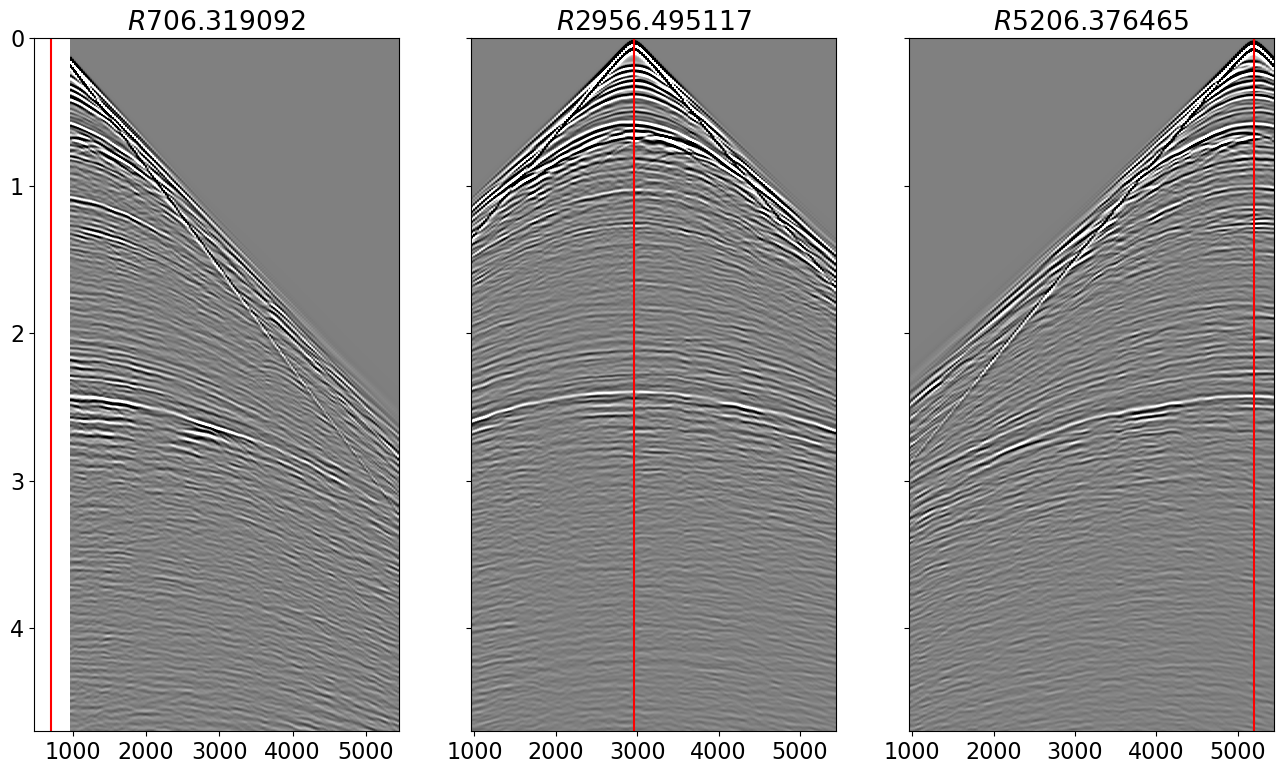

In [4]:
xorig = x[0]
x -= xorig
dx, dz = x[1], z[1]

s[0] -= xorig
r[0] -= xorig

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth local grid')
ax.axis('tight')
plt.colorbar(im)

clip = 0.02
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(d[10].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].axvline(s[0, 10], color='r')
axs[0].set_title(r'$R%f$' % s[0, 10])
axs[0].axis('tight')
axs[1].imshow(d[ns//2].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].axvline(s[0, ns//2], color='r')
axs[1].set_title(r'$R%f$' % s[0, ns//2])
axs[1].axis('tight')
axs[2].imshow(d[-10].T, cmap='gray', vmin=-clip*np.abs(d).max(), vmax=clip*np.abs(d).max(),
              extent = (r[0,0],r[0,-1], t[-1], t[0]))
axs[2].axvline(s[0, -10], color='r')
axs[2].set_title(r'$R%f$' % s[0, -10])
axs[2].axis('tight');

## Kirchhoff Migration

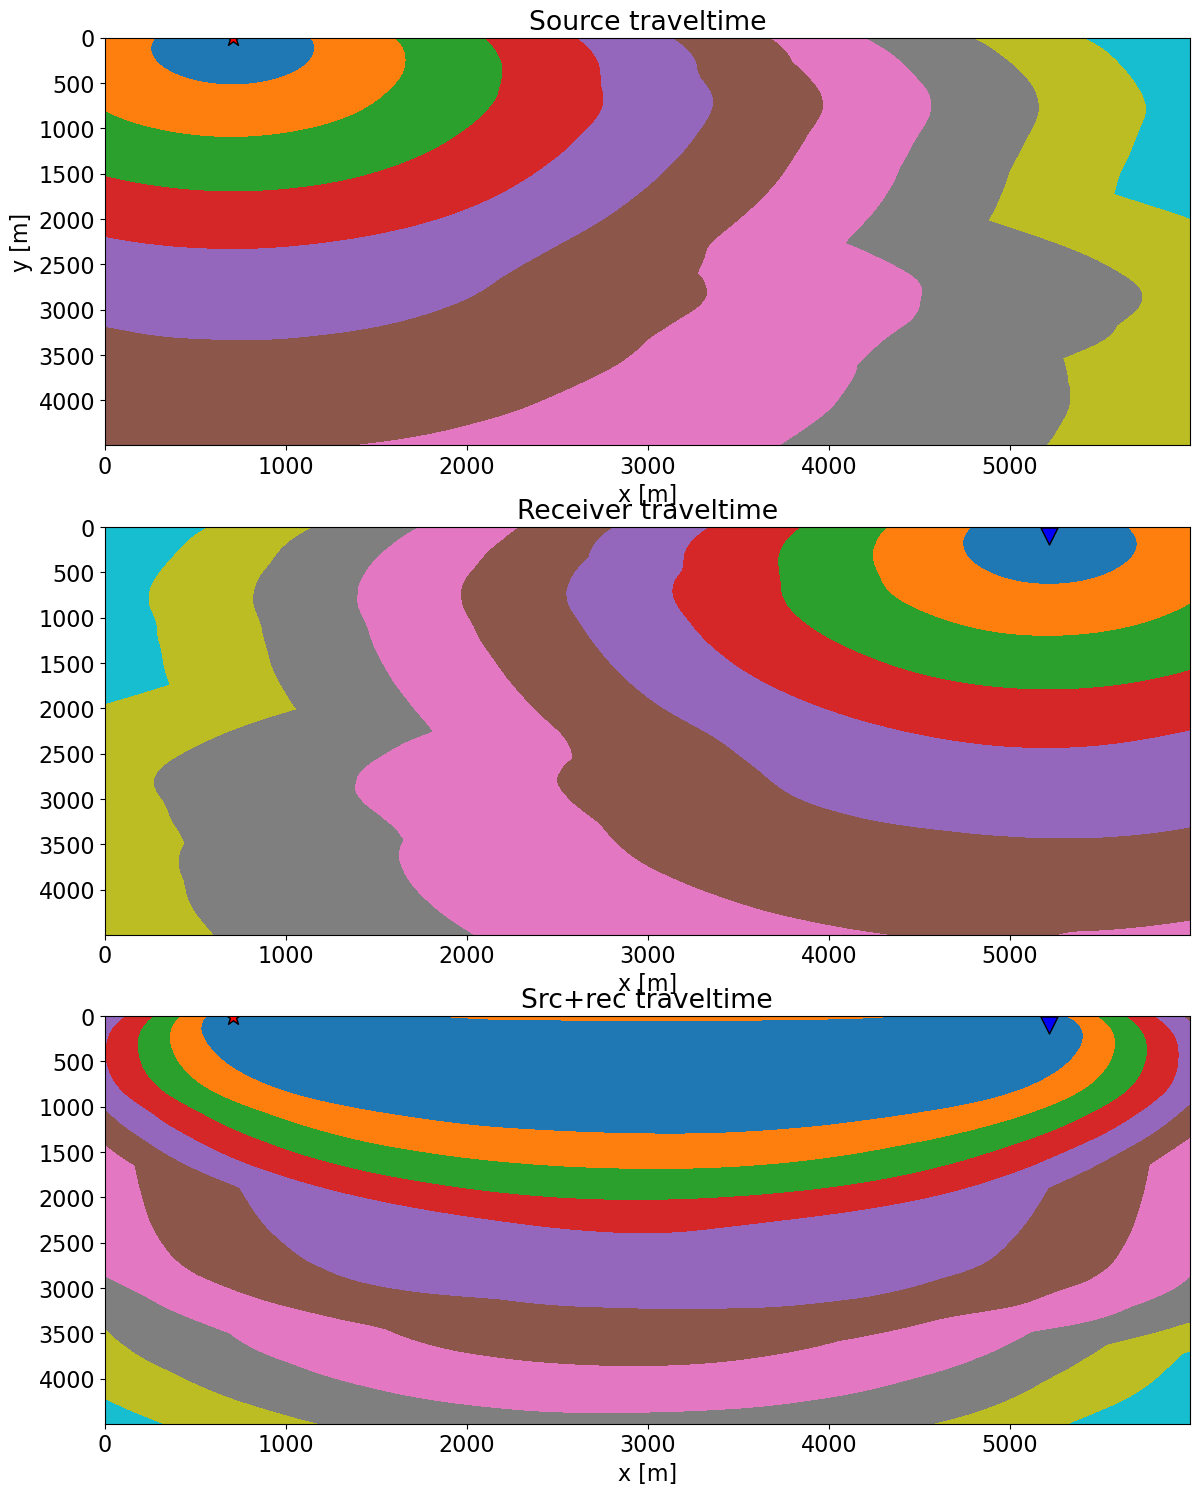

In [5]:
#wav, wavt, wavc = ricker(t[:41], f0=20)
wav, wavc = np.zeros(81), 41
wav[wavc] = 1.
#plt.figure()
#plt.plot(wav)

#KOp = Kirchhoff(z, x, t, s, r, velsm, wav, wavc, dynamic=False, trav=(trav_srcs_eik, trav_recs_eik),
#                mode='byot', engine='numba')
KOp = Kirchhoff(z, x, t, s, r, velsm, wav, wavc, dynamic=False,
                mode='eikonal', engine='numba')


fig, axs = plt.subplots(3, 1, sharey=True, figsize=(14, 18))
axs[0].imshow(KOp.trav_srcs[:, 10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[0].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
axs[0].set_ylim(z[-1], z[0])
axs[1].imshow(KOp.trav_recs[:, -10].reshape((nx, nz)).T, cmap='tab10', 
              extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_title('Receiver traveltime')
axs[1].set_ylim(z[-1], z[0])
axs[2].imshow(KOp.trav_srcs[:, 10].reshape((nx, nz)).T + KOp.trav_recs[:, -10].reshape((nx, nz)).T, 
              cmap='tab10', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(s[0, 10], s[1, 10], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(r[0, -10], r[1, -10], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_title('Src+rec traveltime')
axs[2].set_ylim(z[-1], z[0]);

In [6]:
# migration
image = KOp.H * d
image = image.reshape(nx, nz)

# artifact removal
nsmooth = 10
smooth = np.ones(nsmooth)/nsmooth
imagefilt = image - filtfilt(smooth,1,filtfilt(smooth,1,image).T).T

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Visualization

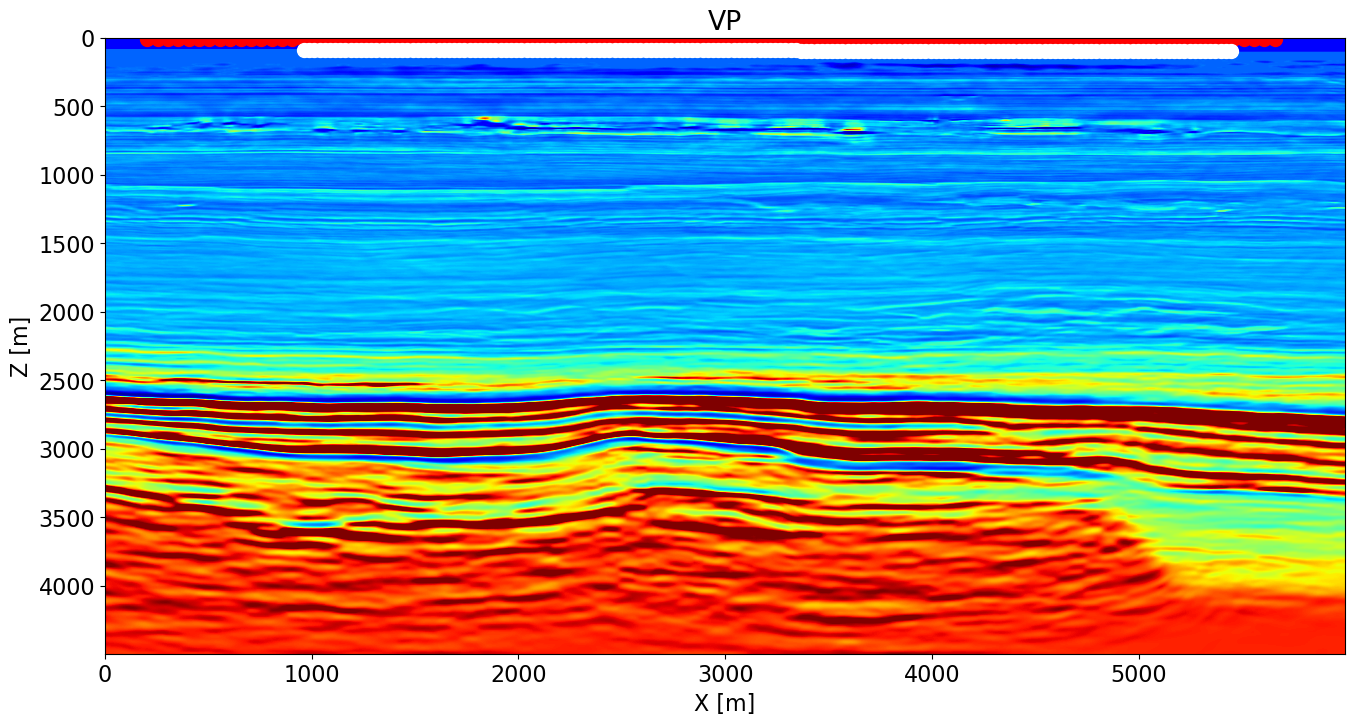

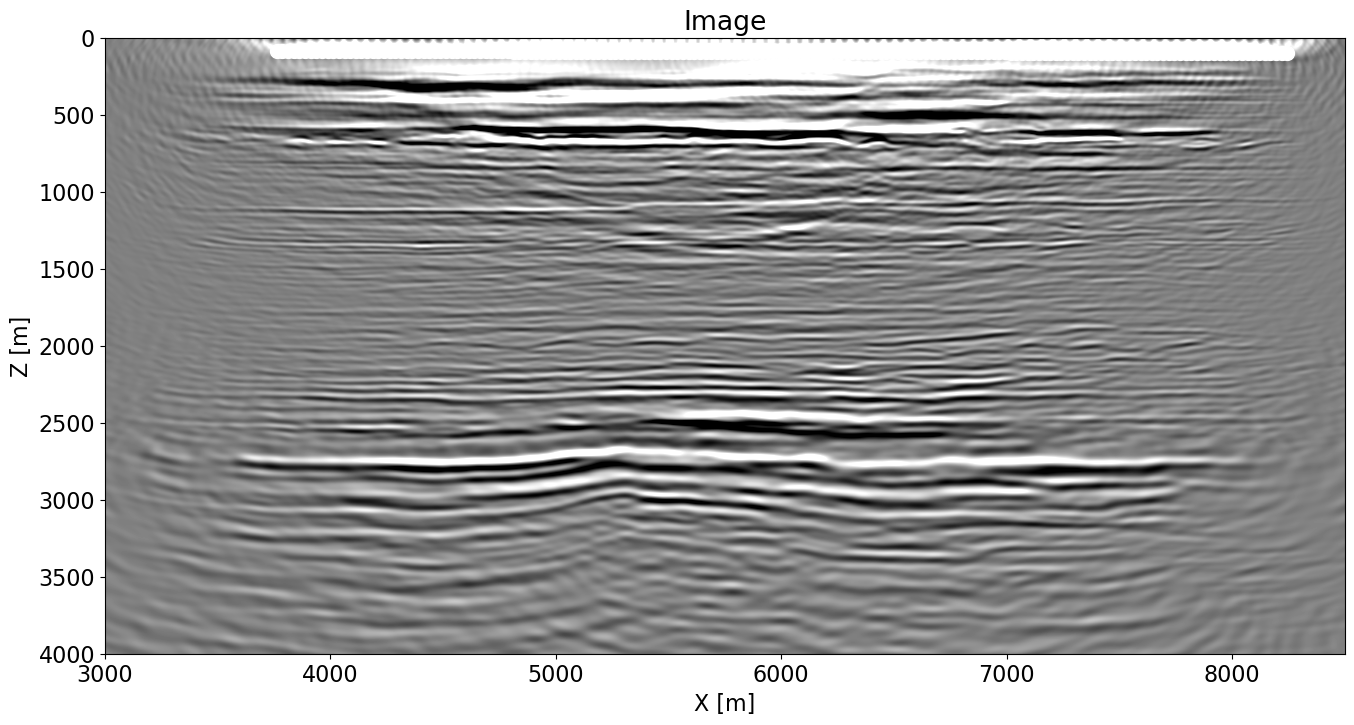

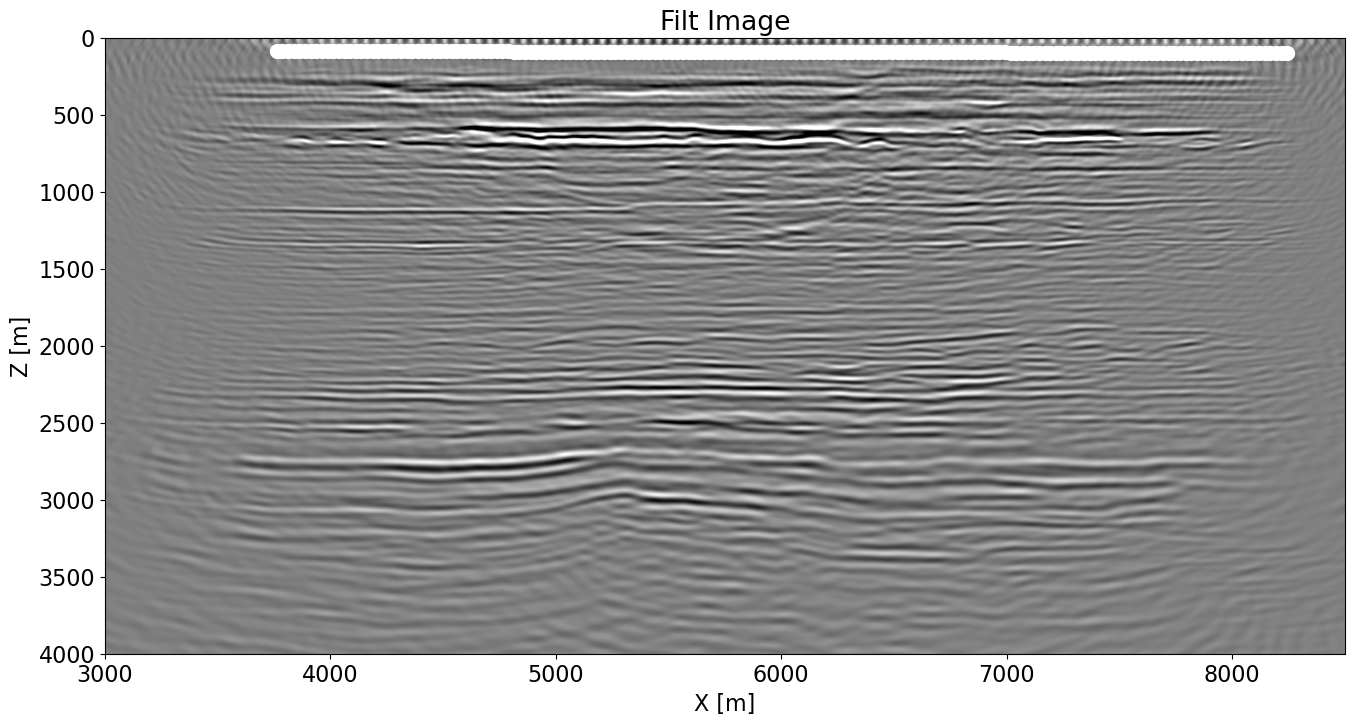

In [7]:
clip = 2e5

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(image.T, cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(x[0]+xorig, x[-1]+xorig, z[-1], z[0]))
ax.plot(r[0]+xorig, r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Image')
ax.axis('tight')
ax.set_xlim(3000, 8500)
ax.set_ylim(4000, 0)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(imagefilt.T, cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(x[0]+xorig, x[-1]+xorig, z[-1], z[0]))
ax.plot(r[0]+xorig, r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Filt Image')
ax.axis('tight')
ax.set_xlim(3000, 8500)
ax.set_ylim(4000, 0);

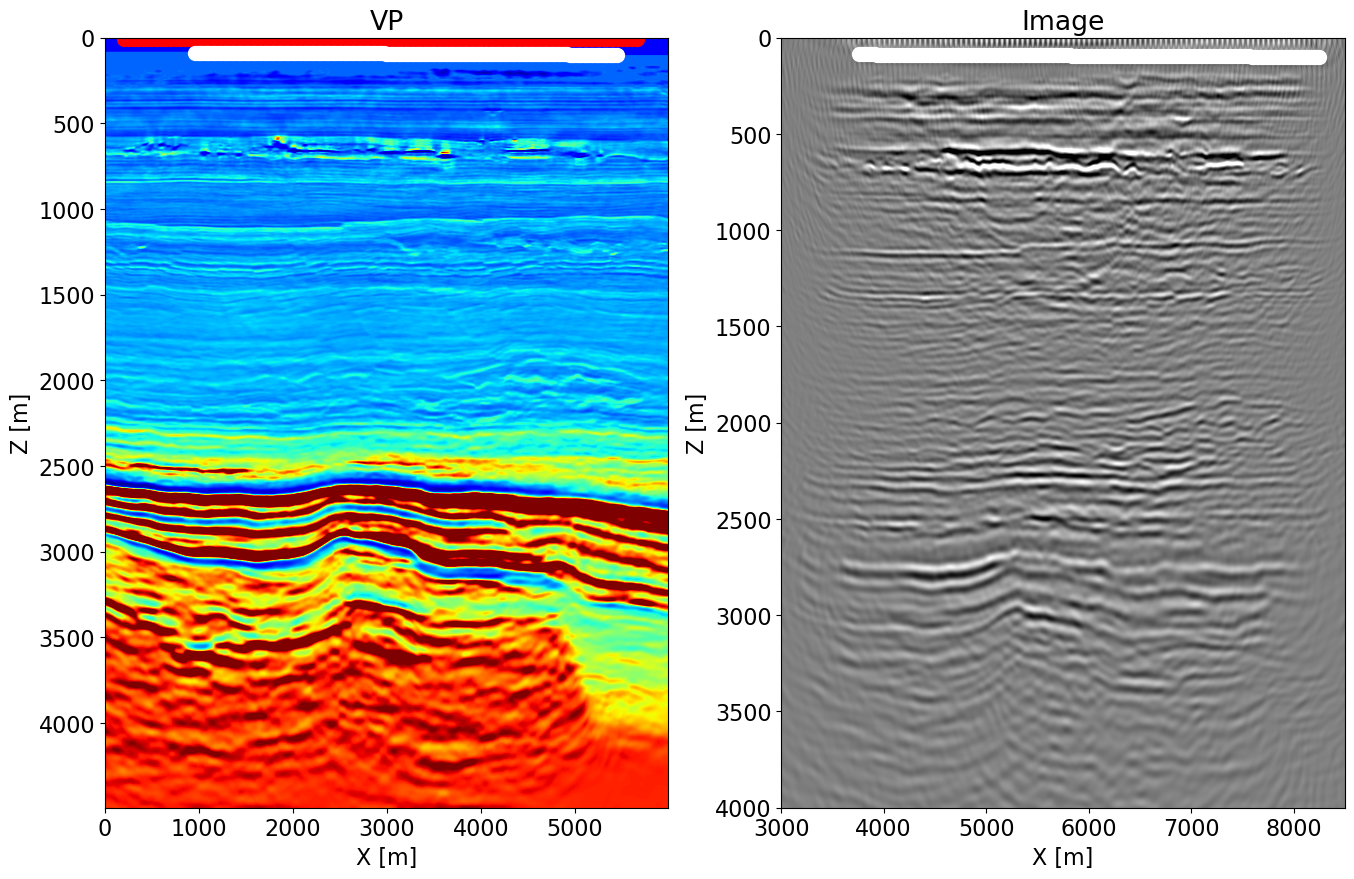

In [8]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 10))
ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')

ax1.imshow(imagefilt.T, cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(x[0]+xorig, x[-1]+xorig, z[-1], z[0]))
ax1.plot(r[0]+xorig, r[1], '.w', ms=20)
ax1.set_xlabel(r'X [m]')
ax1.set_ylabel(r'Z [m]')
ax1.set_title(r'Image')
ax1.axis('tight')
ax1.set_xlim(3000, 8500)
ax1.set_ylim(4000, 0);

In [9]:
np.savez('VolveSynth_Kirchmig_full', image=imagefilt, x=x, z=z)